In [100]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u

import h5py
import glob

In [125]:
### Read in MASCARA data.

mascara_data_LSS = glob.glob('*LSS*')#'red0_vmag_2018Q1LSS.hdf5'
mascara_data_LSC = glob.glob('*LSC*')#sys.argv[2]
mascara_data_LSE = glob.glob('*LSE*')
mascara_data_LSW = glob.glob('*LSW*')

In [131]:
def get_lightcurves(mascara_data, ascc):
    
    camera = []
    for i in range(len(mascara_data)):
        camera.append(h5py.File(mascara_data[i], 'r'))
        
    lc = []
    for i in range(len(camera)):
        lc.append(camera[i]['lightcurves'][ascc][()])
        
    # Remove points binned from <=45 points.
    mask = []
    for i in range(len(lc)):
        mask.append(lc[i]['nobs'] > 45)
        lc[i] = lc[i][mask[i]]

    # Convert lst sequence to lst index.
    lstidx = []
    for i in range(len(lc)):
        lstidx.append(lc[i]['lstseq'] % 270)
        
    return lc, lstidx

lss_lc, lss_idx_season = get_lightcurves(mascara_data_LSS, '2017081')
lsc_lc, lsc_idx_season = get_lightcurves(mascara_data_LSC, '2017081')

In [133]:
def collect_data(lc, idx):
    jd = []
    for i in range(len(lc)):
        jd.append(lc[i]['jd'])
    
    index = []
    for i in range(len(idx)):
        index.append(idx[i])
    
    return np.concatenate(jd) * u.d , np.concatenate(index)

lss_jd, lss_lstidx = collect_data(lss_lc, lss_idx_season)
lsc_jd, lsc_lstidx = collect_data(lsc_lc, lss_idx_season)


In [134]:
### Secondary data calibriation on MASCARA by Local linear method.

# Compute a moving mean along the x-axis.
def moving_mean(x, y, yerr=None, window=3.):
    
    # Set the weights.
    if yerr is None:
        weights = np.ones_like(y)
    else:
        weights = 1/yerr**2

    # Sums for computing the mean.
    sum1 = np.append(0, np.cumsum(weights*y))
    sum2 = np.append(0, np.cumsum(weights))
    
    # Indices at the start and end of the window.
    i = np.searchsorted(x, x - window/2.)
    j = np.searchsorted(x, x + window/2.)
    
    # Compute the mean.
    mean = (sum1[j] - sum1[i])/(sum2[j] - sum2[i])
    
    return mean

# Fit a curve for local linear
def linfit(lstidx, x, y, sky, mag, emag):
    
    sort = np.argsort(lstidx)
    invsort = np.argsort(sort)
    
    lstidx = lstidx[sort]
    x = x[sort]
    y = y[sort]
    sky = sky[sort]
    mag = mag[sort]
    emag = emag[sort]

    _, idx = np.unique(lstidx, return_inverse=True)

    nobs = np.bincount(idx)
    strides = np.append(0, np.cumsum(nobs))

    xbar = np.bincount(idx, x)/np.bincount(idx)
    ybar = np.bincount(idx, y)/np.bincount(idx)

    mat = np.column_stack([np.ones(len(lstidx)), x-xbar[idx], y-ybar[idx], sky])

    pars = np.zeros((len(nobs), 4))
    pars[:,0] = np.bincount(idx, mag/emag**2)/np.bincount(idx, 1/emag**2)

    for i in range(len(nobs)):

        if nobs[i] < 5:
             continue

        i1 = strides[i]
        i2 = strides[i+1]

        pars[i] = np.linalg.lstsq(mat[i1:i2]/emag[i1:i2,None], mag[i1:i2]/emag[i1:i2], rcond=None)[0]

    fit = np.sum(pars[idx]*mat, axis=1)

    fit1 = pars[idx,0]
    fit2 = fit - pars[idx,0]

    return fit1[invsort], fit2[invsort], (nobs > 4)[idx][invsort]

def local_lin(jd, lstseq, x, y, sky, mag, emag, window=5., maxiter=50, dtol=1e-3):
     
    lstidx = (lstseq % 270)
    fit0 = np.zeros(len(jd))
    fit1 = np.zeros(len(jd))

    fit = np.zeros_like(mag)
    for niter in range(maxiter):
        fit1, fit2, mask = linfit(lstidx, x, y, sky, mag - fit0, emag)
        fit0 = moving_mean(jd, mag - fit1 - fit2, emag, window)

        if niter > 0:

            if np.all(np.abs(fit - fit0 - fit1 - fit2) < dtol):
                break

        fit = fit0 + fit1 + fit2

    return fit#, fit0, fit1, fit2, mask

In [135]:
def sec_cali(lc):
    
    vmag = []
    for i in range(len(lc)):
        vmag.append(lc[i]['mag0'] - local_lin(lc[i]['jd'],
                                              lc[i]['lstseq'],
                                              lc[i]['x'],
                                              lc[i]['y'],
                                              lc[i]['sky'],
                                              lc[i]['mag0'],
                                              lc[i]['emag0']))
    
    return np.concatenate([vmag[0], vmag[1], vmag[2], vmag[3]])*(-1)

lss_mag = sec_cali(lss_lc)
lsc_mag = sec_cali(lsc_lc)

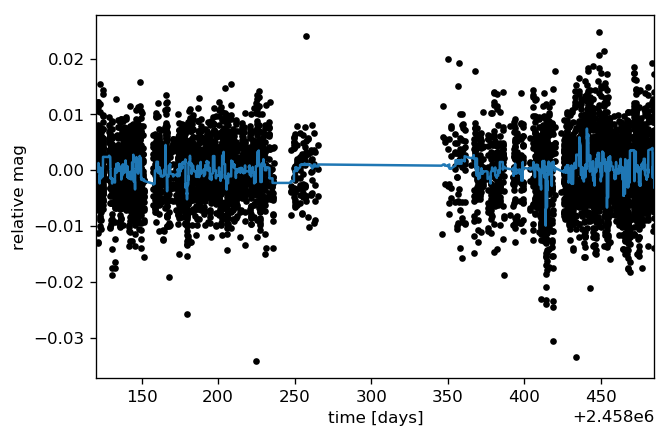

In [130]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
ax.plot(lss_jd, lss_mag, ".k")
ax.set_xlim(lss_jd.min().value, lss_jd.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative mag");

from scipy.signal import medfilt

trend = medfilt(lss_mag, 45)
mu = np.median(lss_mag)

plt.plot(lss_jd, trend)

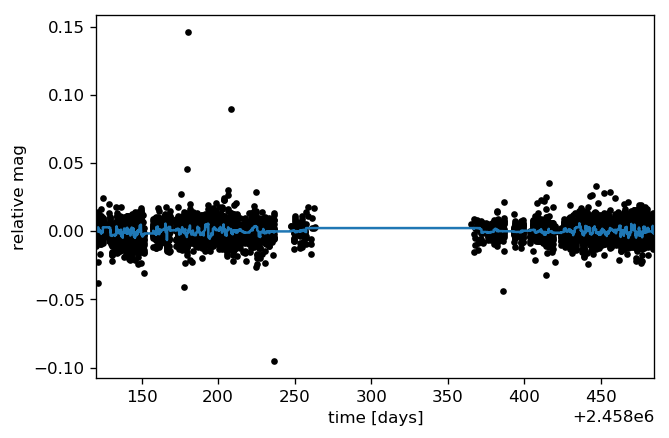

In [136]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
ax.plot(lsc_jd, lsc_mag, ".k")
ax.set_xlim(lsc_jd.min().value, lsc_jd.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative mag");

from scipy.signal import medfilt

trend = medfilt(lsc_mag, 45)
mu = np.median(lsc_mag)

plt.plot(lsc_jd, trend)